# Tarea 3
Juan Pablo Rodas

carnet 23007521

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mypreprocessors as mypp

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Lasso

from feature_engine.imputation import MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import OrdinalEncoder, RareLabelEncoder, CountFrequencyEncoder
from feature_engine.transformation import LogTransformer
from feature_engine.selection import DropFeatures

## Cargamos Datos

In [3]:
dataTrain = pd.read_csv('train.csv')
dataTrain.head()

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,9744,-121.65,36.77,15,2191,358.0,1150,330,4.7969,227500.0,<1H OCEAN
1,13893,-116.27,34.13,37,452,109.0,184,59,3.7292,65800.0,INLAND
2,18277,-122.07,37.34,35,1172,184.0,512,175,7.3561,500001.0,<1H OCEAN
3,16176,-122.39,37.74,52,126,24.0,37,27,10.2264,225000.0,NEAR BAY
4,8843,-118.38,34.09,28,4001,1352.0,1799,1220,2.5784,272900.0,<1H OCEAN


## 1) Columnas que posee faltantes o nulos

In [4]:
cols_con_null = [col for col in dataTrain.columns if (dataTrain[col].isnull().mean() > 0)]
cols_con_null

['total_bedrooms']

In [5]:
cols_con_na = [col for col in dataTrain.columns if (dataTrain[col].isna().mean() > 0)]
cols_con_na

['total_bedrooms']

## 2) Proporcion de faltantes para cada columna con faltantes

In [14]:
prop_null = dataTrain[cols_con_na].isnull().mean()
prop_null

total_bedrooms    0.009483
dtype: float64

<BarContainer object of 1 artists>

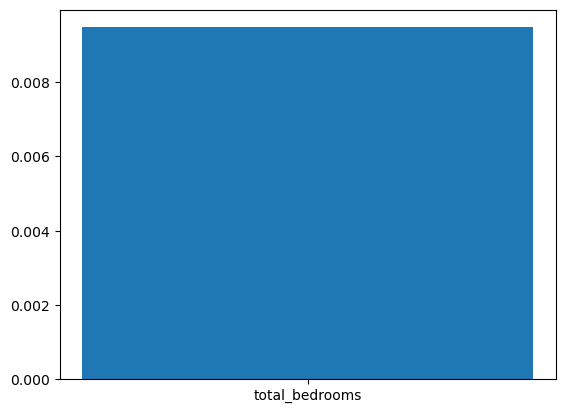

In [15]:
plt.bar(cols_con_na,prop_null)

## 3) Imputacion

<AxesSubplot:>

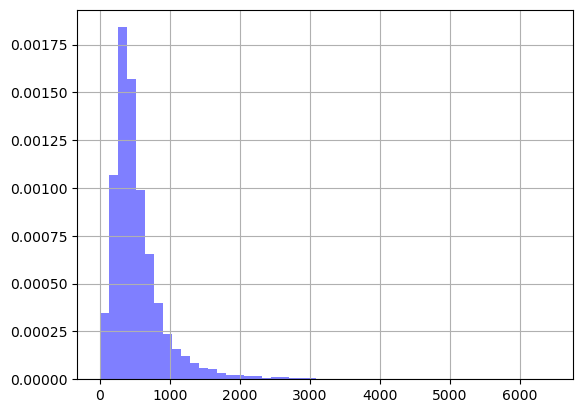

In [24]:
dataTrain['total_bedrooms'].hist(bins=50, density=True, color='blue', alpha=0.5)

se puede aplicar una imputacion por media debnido a que no distorcionaria la forma de la grafica y son menos del 0.9% de los datos

## 4) Imputacion de variables categoricas

no hay variables categoricas que deban ser imputadas

## 5) Codificacion de variables categoricas

In [25]:
def getColumnTypes(dataset):
  '''
  Descripcion: Esta funcion extrae el tipo de dominio de las columnas de un dataset
  Entrada: Pandas Dataframe
  Salida: Tupla con arreglo que contiene nombres de las columnas
  '''
  continuas = []
  discretas = []
  categoricas = []
  for col in dataset.columns:
    if((dataset[col].dtype=='int') or (dataset[col].dtype=='float') or (dataset[col].dtype=='int64')):
      if((len(dataset[col].unique())>30)):
        continuas.append(col)
      else:
        discretas.append(col)
    else:
      categoricas.append(col)

  return continuas, discretas, categoricas

In [27]:
continuas, discretas, categoricas = getColumnTypes(dataTrain)
categoricas

['ocean_proximity']

In [29]:
dataTrain['ocean_proximity'].value_counts().sort_values(ascending=False)

<1H OCEAN     6384
INLAND        4577
NEAR OCEAN    1865
NEAR BAY      1619
ISLAND           2
Name: ocean_proximity, dtype: int64

Evaluando los valores que tiene la columna de ocean_proximity se puede aplicar un frequency encoding debido a que todas las frecuencas son distintas y seria lo mas sencillo y no se obtendria ningun beneficio si se hiciera por OHE o por label encoding

## 6) Scaler

In [113]:
dataTrain.describe()

,id,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,14447.000000,14447.000000,14447.000000,14447.000000,14447.000000,14310.000000,14447.000000,14447.000000,14447.000000,14447.000000
mean,10275.451997,-119.580422,35.642011,28.845435,2635.287534,537.778756,1425.171454,500.116772,3.863949,206873.687824
std,5957.136373,2.003511,2.135526,12.585221,2215.285809,424.012399,1123.733449,386.181946,1.892919,115263.889710
min,1.000000,-124.300000,32.540000,1.000000,2.000000,1.000000,6.000000,1.000000,0.499900,14999.000000
25%,5139.500000,-121.805000,33.930000,18.000000,1444.000000,295.000000,786.000000,280.000000,2.567150,119600.000000
50%,10210.000000,-118.500000,34.260000,29.000000,2121.000000,433.000000,1163.000000,408.000000,3.535000,179700.000000
75%,15449.000000,-118.020000,37.720000,37.000000,3137.500000,647.000000,1722.000000,604.500000,4.722850,264600.000000
max,20640.000000,-114.310000,41.950000,52.000000,39320.000000,6445.000000,28566.000000,6082.000000,15.000100,500001.000000


Si es necesario aplicar un scaler ya que todas las variables se encuentran en escalas distintas

## 7) Pipiline y SMSE

### - Pipeline

In [103]:
DataPipeline = Pipeline([
    # Imputaciones
    ('mean_imputation', 
        MeanMedianImputer(imputation_method='mean', variables=cols_con_na)),

    #Codificacion de variables categoricas
    ('categorical_encoder', 
        CountFrequencyEncoder(encoding_method='count', variables=categoricas)),

    #Feature Scaling
    ('scaler',
        MinMaxScaler()),

    ('modelo_lasso', 
         Lasso(alpha=0.01, random_state=2023)
    )
])

In [100]:
X_train = dataTrain.drop(['id','median_house_value'], axis=1)
y_train = dataTrain['median_house_value']

In [105]:
DataPipeline.fit(X_train,y_train)


Pipeline(steps=[('mean_imputation',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['total_bedrooms'])),
                ('categorical_encoder',
                 CountFrequencyEncoder(variables=['ocean_proximity'])),
                ('scaler', MinMaxScaler()),
                ('modelo_lasso', Lasso(alpha=0.01, random_state=2023))])

### - RMSE

In [106]:
preds = DataPipeline.predict(X_train)

In [107]:
rmseTest = np.sqrt(mean_squared_error(y_train, preds))
rmseTest

68815.80805161363

In [111]:
np.min((y_train)), np.max((y_train))

(14999.0, 500001.0)

In [124]:
round(rmseTest /(np.max((y_train))-np.min((y_train))),3)

0.142

## 8) Dataset Transformado

In [140]:
DataPipelineTransform = Pipeline([
    # Imputaciones
    ('mean_imputation', 
        MeanMedianImputer(imputation_method='mean', variables=cols_con_na)),

    #Codificacion de variables categoricas
    ('categorical_encoder', 
        CountFrequencyEncoder(encoding_method='count', variables=categoricas)),

    #Feature Scaling
    ('scaler',
        MinMaxScaler())
])

In [141]:
DataPipelineTransform.fit(X_train,y_train)

Pipeline(steps=[('mean_imputation',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['total_bedrooms'])),
                ('categorical_encoder',
                 CountFrequencyEncoder(variables=['ocean_proximity'])),
                ('scaler', MinMaxScaler())])

In [142]:
DataOut_X= pd.DataFrame(DataPipelineTransform.transform(X_train))
DataOut_X.columns = X_train.columns
DataOut_X

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,0.265265,0.449522,0.274510,0.055674,0.055400,0.040056,0.054103,0.296341,1.000000
1,0.803804,0.168969,0.705882,0.011445,0.016760,0.006232,0.009538,0.222707,0.716860
2,0.223223,0.510096,0.666667,0.029757,0.028399,0.017717,0.028614,0.472835,1.000000
3,0.191191,0.552604,1.000000,0.003154,0.003569,0.001085,0.004276,0.670784,0.253369
4,0.592593,0.164718,0.529412,0.101709,0.209652,0.062780,0.200460,0.143343,1.000000
...,...,...,...,...,...,...,...,...,...
14442,0.205205,0.555792,0.823529,0.110051,0.172098,0.072829,0.172998,0.170694,0.253369
14443,0.182182,0.549416,0.823529,0.097869,0.157821,0.052206,0.136162,0.208942,0.291915
14444,0.613614,0.228480,0.215686,0.124091,0.124457,0.076401,0.118895,0.252879,0.716860
14445,0.286286,0.630181,0.078431,0.144056,0.182651,0.109699,0.185825,0.197301,0.716860


transformar el DataFrame a un CSV

In [143]:
DataOut_X.to_csv("DataFrameTransformed.csv")